## Home Credit Default Risk

## PART 3: baseline

В этом ноутбуке запуск нескольких моделей на базовом наборе признаков. Я решила остановиться на "деревянных" моделях, так как и домашнее задание на построение ансамблей, и для этой задачи деревья кажутся наиболее подходящими моделями. 

In [1]:
import numpy as np
import pandas as pd
import pickle

from cross_validation_module import *
from submission_module import *

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm_notebook
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import plotly.plotly as py
import cufflinks as cf
sns.set_style('whitegrid')
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 250)

In [2]:
with open('columns_vocab.pkl', 'rb') as f: 
    columns_vocab = pickle.load(f)
    
APPL_ID = 0
columns_vocab[APPL_ID].keys()

dict_keys(['column_id', 'column_target', 'columns_binary', 'columns_category', 'columns_float', 'columns_float_avg', 'columns_float_mode', 'columns_float_medi', 'columns_float_social_circle', 'new_features', 'columns_category_ohe', 'columns_float_log', 'columns_social_circle_log'])

In [3]:
with open('df_application_train_upd.pkl', 'rb') as f: 
    df_application_train = pickle.load(f)
    
with open('df_application_test_upd.pkl', 'rb') as f: 
    df_application_test = pickle.load(f)

In [4]:
print('application train:', df_application_train.shape)
print('application test:', df_application_test.shape)

application train: (307511, 324)
application test: (48744, 323)


## BASELINES

Будем использовать все признаки, какие есть в данных. Новые включать не будем. 

In [20]:
column_id = columns_vocab[APPL_ID]['column_id']
column_target = columns_vocab[APPL_ID]['column_target']

columns = columns_vocab[APPL_ID]['columns_float'] + \
                    columns_vocab[APPL_ID]['columns_binary'] + \
                    columns_vocab[APPL_ID]['columns_category_ohe'] + \
                    columns_vocab[APPL_ID]['columns_float_social_circle'] + \
                    columns_vocab[APPL_ID]['columns_float_avg'] + \
                    columns_vocab[APPL_ID]['columns_float_mode'] + \
                    columns_vocab[APPL_ID]['columns_float_medi']
    
len(main_columns)

275

Для кросс-валидации будем использовать StratifiedShuffleSplit: 

In [6]:
folds = get_cv_folds(df_application_train, column_target, n_splits=5)

Попробуем сначала запустить Random Forest с параметрами по умолчанию: 

### Baseline - RandomForest

In [22]:
%%time

model = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)

train_roc_auc, valid_roc_auc = cross_validation(df_application_train, columns, column_target, \
                                             folds, model, roc_auc_score)

train_roc_curve, valid_roc_curve = cross_validation(df_application_train, columns, column_target, \
                                        folds, model, roc_curve)

CPU times: user 4min 19s, sys: 10.6 s, total: 4min 29s
Wall time: 1min 45s


mean train score: 0.9998107887440675
mean valid score: 0.6152767217707196


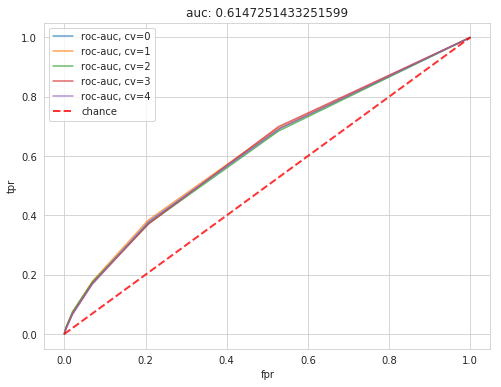

In [23]:
print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

plot_roc_curve_cv(valid_roc_curve)

Результат на валидации не очень, на трейне почти 1. Модель переобучилась. Результат на каггле тоже не самый лучший. 

In [26]:
%%time
# private score = 0.59823
# public score = 0.61280
model = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)
make_prediction(df_application_train, df_application_test, columns, column_target, model, \
                'baseline', 'rf')

CPU times: user 35.9 s, sys: 750 ms, total: 36.7 s
Wall time: 13.1 s


Сделаем то же самое бустингом на xgboost.

### Baseline - xgboost

In [24]:
params = {
            # General Parameters
            'booster': 'gbtree', 
            'silent': 1,
            
            # Parameters for Tree Booster
            'eta':0.3,
            'max_depth':5,
            'scale_pos_weight': 11, 
            
            # Learning Task Parameters
            'objective':'binary:logistic',
            'eval_metric': 'auc',
            'seed': 0, 
        }
num_rounds=25

In [25]:
%%time
train_roc_auc, valid_roc_auc = cross_validation_xgboost(df_application_train, columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_auc_score)

train_roc_curve, valid_roc_curve = cross_validation_xgboost(df_application_train, columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_curve)

CPU times: user 20min 23s, sys: 21.3 s, total: 20min 44s
Wall time: 6min 45s


mean train score: 0.7818435860647698
mean valid score: 0.7494203469583057


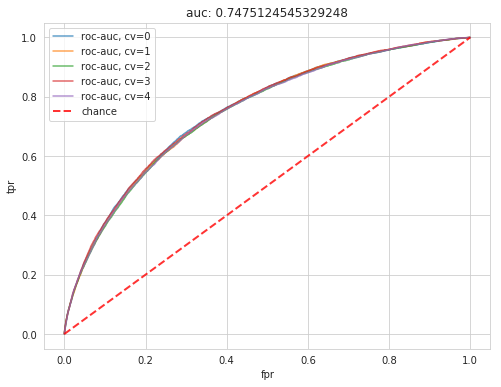

In [26]:
print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

plot_roc_curve_cv(valid_roc_curve)

И попробуем библиотеку ligthgbm:

### Baseline - lightgbm

In [27]:
params = {
    # Core parameters
    'objective': 'binary', 
    'learning_rate': 0.1, 
    'num_leaves': 31, 
    'num_threads': 0, 
    'seed': 0, 
    
    # Learning Control Parameters
    'early_stopping_round': 10, 
    
    # IO Parameters
    
    # Objective Parameters
    #'is_unbalance': True, 
    'scale_pos_weight': 11, 
    
    # Metric Parameters
    'metric': 'auc', 
}
num_rounds = 100

In [28]:
%%time
train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_auc_score, 
                                    verbose_eval=False)

train_roc_curve, valid_roc_curve = cross_validation_lightgbm(df_application_train, columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_curve, 
                                    verbose_eval=False)

CPU times: user 8min 12s, sys: 22.8 s, total: 8min 35s
Wall time: 3min 1s


mean train score: 0.7993151574846682
mean valid score: 0.7548756917696756


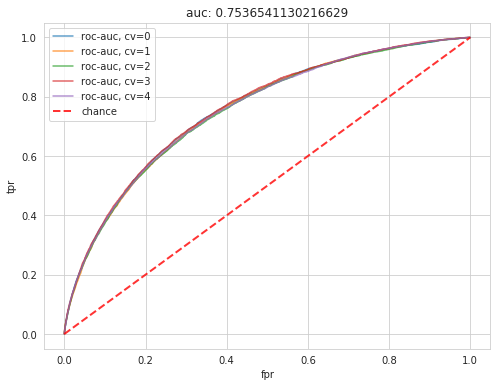

In [29]:
print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

plot_roc_curve_cv(valid_roc_curve)

Результаты с бустингом в двух библиотеках очень похожи, только c lightgbm все считается быстрее. Его и будем использовать дальше. 

Ну и на каггле результаты подтянулись: 

In [87]:
# private score = 0.74263
# public score = 0.74348
predict_submission_lightgbm(df_application_train, df_application_test, 
                           columns, column_target, params, num_rounds, 
                           'baseline', 'lgb')